## Import packages

In [ ]:
import utils
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

## Data augmentation parameters

To fix the imbalanced classed problem, you want the augmented data to have a number of samples for species $i$ equal to:
$$ C \times \frac{N}{K} $$
i.e, you want to multiply each class $i$ by a factor:
$$ \frac{N}{n_{i}} \times \frac{C}{K} $$
with:
- $N$ being the total size of the original dataset
- $n_i$ the number of samples for species $i$ in the original dataset
- $C$ the augmentation factor
- $K$ the number of species, i.e K = 8

In [ ]:
BALANCE_CLASSES: bool = True # Should the augmented data have as many samples in each species ?
AUGMENTATION_FACTOR: float = 5. # The size factor that we want to multiply our data with
RNG_SEED: int = 42 # The seed for the random effects of data augmentation

# Augmented Data Generator parameters
# Transformations
ROTATION_RANGE: float = 100. # Max rotation in degrees
ZOOM_RANGE: float = 0.4 # Max zoom
WIDTH_SHIFT_RANGE: int = 15 # Horizontal shift (in pixels)
HEIGHT_SHIFT_RANGE: int = 15 # Vertical shift (in pixels)
HORIZONTAL_FLIP: bool = True # Horizontal flip
VERTICAL_FLIP: bool = True # Vertical flip
BRIGHTNESS_SHIFT_RANGE: list[float] = [0.4, 1.4] # Minimum and max brightness scaling
SHEAR_RANGE: float = 10. # Max shear in degrees

FILL_MODE: str = "reflect" # Filling method for out-of-border pixels

Question:  
Does an augmented data generator object apply different random transformations at each epoch ?

Answer:  
Yes it does, augmentation happens epoch-wise, which means the **AUGMENTATION_FACTOR** parameter is irrelevant.  

**BUT** it converts one input image to one augmented image, which means the augmented dataset will still have unbalanced classes.  
  
Questions:
- Is that a problem ? 
- If it is, then we have 2 options: either **loss ponderation** (built-in TensforFlow) or **balanced augmented dataset**: *BUT HOW?*  

Answer:
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#oversampling  
-> Resample aléatoirement un nombre $m_i$ dans les classes minoritaires avant d'appliquer la transformation where:
$$ \max_{j}{n_j} - n_i$$

In [ ]:
n_resamples: dict[str, int] = {}
for species in utils.labels:
    mi = max(utils.n_images.values()) - utils.n_images[species]
    n_resamples[species] = mi
    print("Number of resamples needed for %s: %d" % (species, mi))

plt.bar(np.arange(1, utils.n_species + 1), n_resamples.values())
plt.title("Number of resamples needed for each species for equally distributed training data")

## Complete augmentation data generator

In [ ]:
complete_aug_data_gen = ImageDataGenerator(
    rotation_range=ROTATION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    brightness_range=BRIGHTNESS_SHIFT_RANGE,
    shear_range=SHEAR_RANGE,
    zoom_range=ZOOM_RANGE,
    fill_mode=FILL_MODE,
    horizontal_flip=HORIZONTAL_FLIP,
    vertical_flip=VERTICAL_FLIP,
)

ImageDataGenerator has parameters:
- featurewise_center: $bool$
- samplewise_center=False: $bool$
- featurewise_std_normalization: $bool$
- samplewise_std_normalization: $bool$
It also has validation_split: $float \in [0;1]$. Is this when the validation data is generated ?

Question:
But when does batch norm take place ?

In [ ]:
aug_data = complete_aug_data_gen.flow_from_directory(
    utils.data_dir,
    target_size = (utils.input_height, utils.input_width),
    seed=RNG_SEED
)

Returned a tuple for each batch containing:
- a np.ndarray of dimension 3 where $a_{ijk}$ is the value of the $k$-th channel in the $j$-th pixel of the $i$-th image
- a 1-dimensional array corresponding to the $i$ labels

### Plot one random image of each class along with a random augmented version of it (randomly transformed according to the data genarator parameters):

In [ ]:
import os
from PIL import Image

np.random.seed(RNG_SEED)

num_row = 4
num_col = 4
fig, axes = plt.subplots(num_row, num_col)
axes = axes.flatten()

for i in range(utils.n_species):
    class_images = os.listdir("{}/{}".format(utils.data_dir, utils.labels[i]))
    img_file = class_images[np.random.randint(len(class_images))]
    img = Image.open('{}/{}/{}'.format(utils.data_dir, utils.labels[i], img_file))
    img_array = np.array(img)
    axes[2*i].imshow(img_array)
    transformed_img = np.array(complete_aug_data_gen.random_transform(img_array, seed=RNG_SEED), dtype=np.uint8)
    axes[2*i+1].imshow(transformed_img)
    axes[2*i].axis(False)
    # axes[2*i].set_title(f"spec{i} original")
    axes[2*i+1].axis(False)
    # axes[2*i+1].set_title(f"spec{i} transformed")

plt.tight_layout()
plt.axis(False)
plt.show()

### Plot one image and 15 variations of it

In [ ]:
data = ImageDataGenerator().flow_from_directory(utils.data_dir, shuffle=True, seed=RNG_SEED)

img = np.array(Image.open(data.filepaths[np.random.randint(32)]))

num_row = 4
num_col = 4
fig, axes = plt.subplots(num_row, num_col)
axes = axes.flatten()

axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis(False)

for i in range(1, num_row * num_col):
    axes[i].imshow(np.array(complete_aug_data_gen.random_transform(img) / 255))
    axes[i].axis(False)

Question:  
Does an augmented data generator object apply different random transformations at each epoch ?

Answer:  
Yes it does, augmentation happens epoch-wise, which means the **AUGMENTATION_FACTOR** parameter is irrelevant.  

**BUT** it converts one input image to one augmented image, which means the augmented dataset will still have unbalanced classes.  
  
Questions:
- Is that a problem ? 
- If it is, then we have 2 options: either **loss ponderation** (built-in TensforFlow) or **balanced augmented dataset**: *BUT HOW?*  

Answer:
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#oversampling  
-> Resample aléatoirement un nombre $m_i$ dans les classes minoritaires avant d'appliquer la transformation where:
$$ \max_{j}{n_j} - n_i$$

Number of resamples needed for Species1: 351
Number of resamples needed for Species2: 5
Number of resamples needed for Species3: 22
Number of resamples needed for Species4: 26
Number of resamples needed for Species5: 6
Number of resamples needed for Species6: 315
Number of resamples needed for Species7: 0
Number of resamples needed for Species8: 29


Text(0.5, 1.0, 'Number of resamples needed for each species for equally distributed training data')

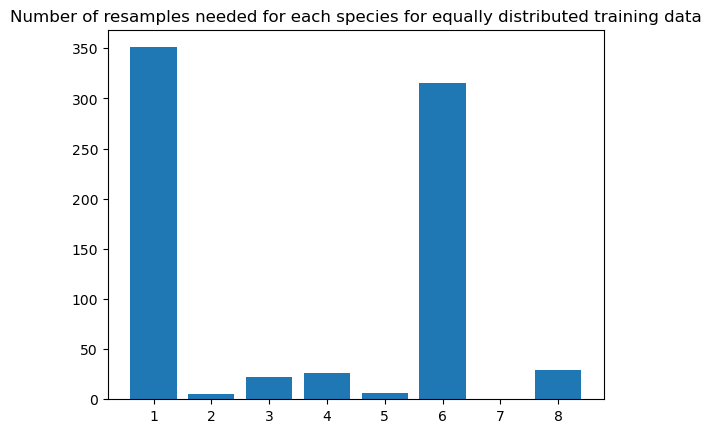

In [3]:
n_resamples: dict[str, int] = {}
for species in utils.labels:
    mi = max(utils.n_images.values()) - utils.n_images[species]
    n_resamples[species] = mi
    print("Number of resamples needed for %s: %d" % (species, mi))

plt.bar(np.arange(1, utils.n_species + 1), n_resamples.values())
plt.title("Number of resamples needed for each species for equally distributed training data")

## Complete augmentation data generator

In [4]:
complete_aug_data_gen = ImageDataGenerator(
    rotation_range=ROTATION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    brightness_range=BRIGHTNESS_SHIFT_RANGE,
    shear_range=SHEAR_RANGE,
    zoom_range=ZOOM_RANGE,
    fill_mode=FILL_MODE,
    horizontal_flip=HORIZONTAL_FLIP,
    vertical_flip=VERTICAL_FLIP,
)

ImageDataGenerator has parameters:
- featurewise_center: $bool$
- samplewise_center=False: $bool$
- featurewise_std_normalization: $bool$
- samplewise_std_normalization: $bool$
It also has validation_split: $float \in [0;1]$. Is this when the validation data is generated ?

Question:
But when does batch norm take place ?

In [5]:
aug_data = complete_aug_data_gen.flow_from_directory(
    utils.data_dir,
    target_size = (utils.input_height, utils.input_width),
    seed=RNG_SEED
)

Found 3542 images belonging to 8 classes.


Returned a tuple for each batch containing:
- a np.ndarray of dimension 3 where $a_{ijk}$ is the value of the $k$-th channel in the $j$-th pixel of the $i$-th image
- a 1-dimensional array corresponding to the $i$ labels

### Plot one random image of each class along with a random augmented version of it (randomly transformed according to the data genarator parameters):

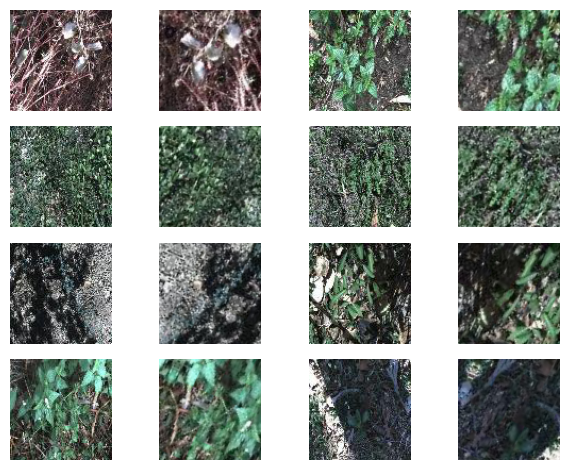

In [6]:
import os
from PIL import Image

np.random.seed(RNG_SEED)

num_row = 4
num_col = 4
fig, axes = plt.subplots(num_row, num_col)
axes = axes.flatten()

for i in range(utils.n_species):
    class_images = os.listdir("{}/{}".format(utils.data_dir, utils.labels[i]))
    img_file = class_images[np.random.randint(len(class_images))]
    img = Image.open('{}/{}/{}'.format(utils.data_dir, utils.labels[i], img_file))
    img_array = np.array(img)
    axes[2*i].imshow(img_array)
    transformed_img = np.array(complete_aug_data_gen.random_transform(img_array, seed=RNG_SEED), dtype=np.uint8)
    axes[2*i+1].imshow(transformed_img)
    axes[2*i].axis(False)
    # axes[2*i].set_title(f"spec{i} original")
    axes[2*i+1].axis(False)
    # axes[2*i+1].set_title(f"spec{i} transformed")

plt.tight_layout()
plt.axis(False)
plt.show()

### Plot one image and 15 variations of it

Found 3542 images belonging to 8 classes.


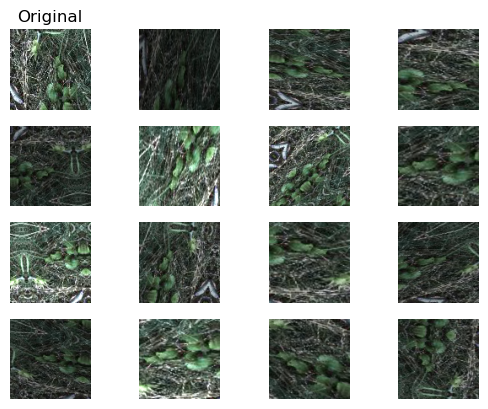

In [7]:
data = ImageDataGenerator().flow_from_directory(utils.data_dir, shuffle=True, seed=RNG_SEED)

img = np.array(Image.open(data.filepaths[np.random.randint(32)]))

num_row = 4
num_col = 4
fig, axes = plt.subplots(num_row, num_col)
axes = axes.flatten()

axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis(False)

for i in range(1, num_row * num_col):
    axes[i].imshow(np.array(complete_aug_data_gen.random_transform(img) / 255))
    axes[i].axis(False)